# Test of Markowitz optimization on different time periods of the same portfolio universe

In [1]:
import pandas as pd, numpy as np, scipy.optimize as sciop
import matplotlib.pyplot as plt


class Markowitz(object):
    def __init__(self, df_log_returns, observation_start, observation_end , frequency_of_observations, can_short = False):
        self.df_log_returns = df_log_returns
        self.observation_start = observation_start
        self.observation_end = observation_end
        self.frequency_of_observations = frequency_of_observations
        self.can_short = can_short
        
        # Tickers in this portfolio
        self.tickers = list(self.df_log_returns.columns.values)

        # additional attributes and calculations
        self.df_slice =  self.df_log_returns[self.observation_start : self.observation_end]
        self.mean_returns = self.df_slice.mean()
        
        self.num_tickers = len(self.tickers)
        weight_guess = self.num_tickers * [1. /self.num_tickers]

        self.cov_frame = self.df_slice.cov() * self.frequency_of_observations

        # Handling shorts
        if self.can_short:
            cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
            bnds = tuple((-0.1,1) for x in range(self.num_tickers)) 
        else:
            cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
            bnds = tuple((0,1) for x in range(self.num_tickers)) 

        self.bounds = bnds # to be used for efficient frontier.

        self.portfolio_allocation = sciop.minimize(self.max_sharpe_ratio,
                      weight_guess,
                      method = 'SLSQP',
                      bounds= bnds,
                      constraints = cons)['x'].round(3)
        
        # self.portfolio_allocation = opt['x'].round(3)
        
        ticker_dictionary = {}
        for i in range(self.num_tickers):
            ticker_dictionary[self.tickers[i]] = self.portfolio_allocation[i]

        self.allocation_by_ticker = ticker_dictionary


    def max_sharpe_ratio(self, weights):
        weight_array = np.array(weights)
        self.portfolio_return = np.sum(self.mean_returns * weight_array) * self.frequency_of_observations
        self.portfolio_volatility = np.sqrt(np.dot(weight_array.T,
                                                    np.dot(self.cov_frame, 
                                                            weight_array)))
        sharp_ratio = self.portfolio_return / self.portfolio_volatility
        self.sharp_ratio = sharp_ratio
        return -sharp_ratio

    def display_portfolio_statistics(self):
        print('Expected Portfolio Return: {}'.format(self.portfolio_return))
        print('Portfolio Volatility: {}'.format(self.portfolio_volatility))
        print('Portfolio\'s Sharpe Ratio: {}'.format(self.sharp_ratio))

    def display_summary(self):
        pass

    def minimize_volatility(self, weights):
        weight_array = np.array(weights)
        temp_return = np.sum(self.mean_returns * weight_array)*self.frequency_of_observations
        temp_volatility = np.sqrt(np.dot(weight_array.T, np.dot(self.cov_frame , weight_array)))
        return np.array([temp_return, temp_volatility])

    def minimize_volatility_helper(self, weights):
        return self.minimize_volatility(weights)[1]

    def display_efficient_frontier(self, include_random_plots = False, include_messages = False):
        if include_messages:
            print('Calculating Efficient Frontier')
        
        # calculate y axis window bounds, so as to not overplot
        y_ceiling = max(self.mean_returns*self.frequency_of_observations)

        # but just in case the window is too high        
        if y_ceiling > 0.5:
            y_ceiling = 0.5
        
        if include_messages:
            print('Ceiling is {}'.format(y_ceiling))


        target_returns = np.linspace(0.0, y_ceiling, num = 30)
        target_volatilities = []
        counter = 1
        weight_guess = self.num_tickers * [1. /self.num_tickers]
        for target in target_returns:
            cons = ({'type': 'eq', 'fun': lambda x, target = target: self.minimize_volatility(x)[0] - target},
                    {'type': 'eq', 'fun': lambda x: np.sum(x)-1})
            frontier_point = sciop.minimize(self.minimize_volatility_helper,
                                            weight_guess,
                                            bounds = self.bounds,
                                            constraints= cons)
            if include_messages:
                print("Found "+ str(counter) + " target volatilities")
            counter += 1
            target_volatilities.append(frontier_point['fun'])
        target_volatilities = np.array(target_volatilities)
        
        plt.figure(figsize= (8,6))
        plt.scatter(target_volatilities, target_returns, c = target_returns / target_volatilities, marker= 'x')
        plt.plot(self.portfolio_volatility, self.portfolio_return, 'r*', markersize = 16.0)
        
        #generate random allocations for plotting
        if include_random_plots:      
            random_returns_array= []
            random_vols_array = []

            for roll in range(1000):
                random_weights = np.random.random(self.num_tickers)
                random_weights /= np.sum(random_weights)
                random_returns_array.append(np.sum(self.mean_returns* random_weights)*self.frequency_of_observations)
                random_vols_array.append(np.sqrt(np.dot(random_weights.T, np.dot(self.cov_frame, random_weights))))

            random_returns_array = np.array(random_returns_array)
            random_vols_array = np.array(random_vols_array)

            plt.scatter(random_vols_array, random_returns_array, c = random_returns_array/random_vols_array, marker = 'o')
        
        # plot everything.
        plt.grid(True)
        #plt.xlim(-0.1, 0.4)
        #plt.ylim(-0.2, 0.5)
        plt.colorbar(label = 'Sharpe ratio')
        plt.show(block = True)


    def allocate_weights(self):
        return self.portfolio_allocation

In [2]:
df = pd.read_pickle('silly_strat_dataframe.pkl')
df_log = np.log(df/ df.shift(1))

In [4]:
port = Markowitz(df_log, '2015', '2016', 252)

In [5]:
port.display_portfolio_statistics()

Expected Portfolio Return: 0.3064357191130685
Portfolio Volatility: 0.13717771617430533
Portfolio's Sharpe Ratio: 2.233859315194422


In [6]:
print(port.allocation_by_ticker)

{'ACLS': 0.0, 'AIMC': 0.0, 'AKBA': 0.0, 'AMT': 0.0, 'ANDE': 0.0, 'AROC': 0.0, 'ATRA': 0.0, 'BG': 0.0, 'BKNG': 0.0, 'CBS': 0.0, 'CRS': 0.0, 'CSGS': 0.133, 'DD': 0.0, 'DXC': 0.115, 'FBMS': 0.2, 'FHB': 0.0, 'FORM': 0.0, 'GE': 0.0, 'GFF': 0.142, 'GOOD': 0.0, 'HELE': 0.0, 'KIM': 0.0, 'LAMR': 0.0, 'LAND': 0.0, 'LMNX': 0.0, 'LOW': 0.0, 'NKSH': 0.028, 'RILY': 0.088, 'RSG': 0.293, 'S': 0.0, 'SIGI': 0.0, 'SNPS': 0.0, 'TELL': 0.002, 'TEX': 0.0, 'TLRA': 0.0, 'TWIN': 0.0, 'VEEV': 0.0}


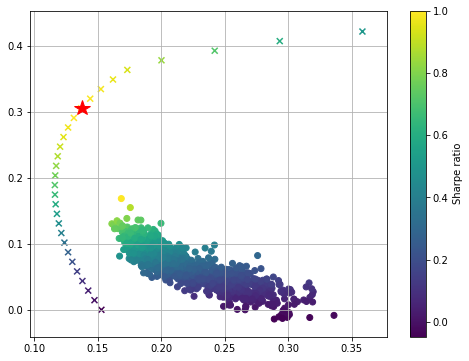

In [8]:
port.display_efficient_frontier(True)

# An example of same portfolio at a different time with different observation period.

In [10]:
port_different_time_period = Markowitz(df_log, '2017', '2017-12-31', 252)

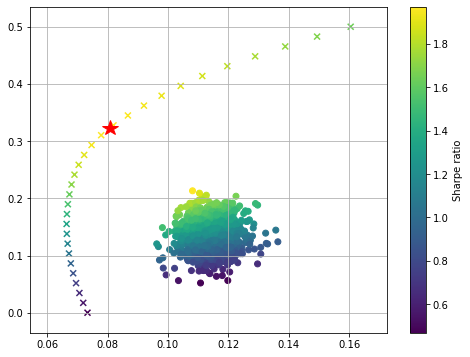

In [11]:
port_different_time_period.display_efficient_frontier(True)

# Yet another example of same portfolio at a different time with similiar observation period.

In [12]:
port_another_example = Markowitz(df_log, '2018', '2018-12-31', 252)

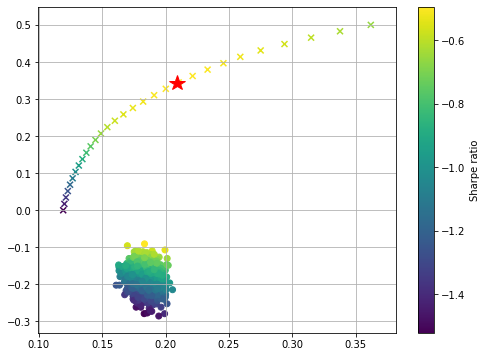

In [13]:
port_another_example.display_efficient_frontier(True)

# more portfolios

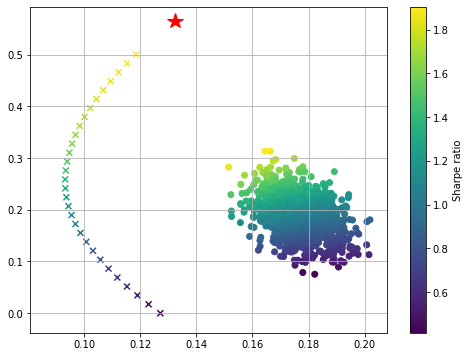

In [16]:
port_2 = Markowitz(df_log, '2019', '2020', 252)
port_2.display_efficient_frontier(True)

# very similar but with slightly different observation frequency

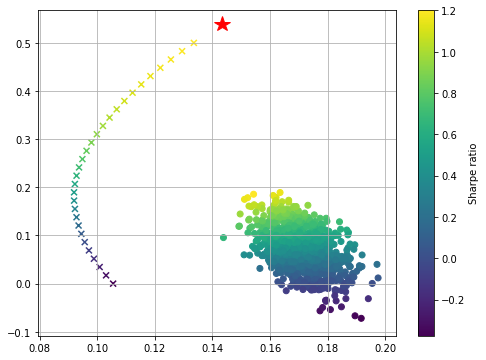

In [19]:
port_3 = Markowitz(df_log, '2019-1-31', '2020', 252)
port_3.display_efficient_frontier(True)

# Testing the class and logic

Test: Provide a datetime that is outside the scope of the datatime indexes in the dataframe. 

Theory: Will not cause a failure. Datetimes are handled well in pandas. For instance, if a dataframe datetime index ranges from `2013-03-14` to `2013-04-21` and is sliced on `2013-02-27` to `2013-05-31` then the slice returned is simply the original dataframe. No errors should occur. Similiarly, a slice that starts outside the scope but ends within the scope such as taking `2013-02-27` to `2013-03-31` and slicing on the hypothetical dataframe will generate a dataframe ranging from `2013-03-13` to `2013-03-31`. You can imagin what the opposite would look like... 

To prove this: Take a slice generated from an out of scope datetime with an in scope ending and compare it to one with both an in scope beginning and ending.

The `silly_strat_dataframe` I've been working with starts on the first trading day of 2015 and ends sometime in late 2019. The following should be equivalent

In [6]:
port_test_1 = Markowitz(df_log, '2014', '2016', 252)
port_test_1.display_portfolio_statistics()



Expected Portfolio Return: 0.3064357191130685
Portfolio Volatility: 0.13717771617430533
Portfolio's Sharpe Ratio: 2.233859315194422


In [7]:
port_test_2 = Markowitz(df_log, '2015', '2016', 252)
port_test_2.display_portfolio_statistics()

Expected Portfolio Return: 0.3064357191130685
Portfolio Volatility: 0.13717771617430533
Portfolio's Sharpe Ratio: 2.233859315194422


### Result: Theory turned out correct.